In [1]:
from data_loader import *
dataset = FNNDataset(root='data', feature='hand', empty=False, name='gossipcop', transform=ToUndirected())

In [2]:
dataset

gossipcop(5464)

In [3]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: gossipcop(5464):
Number of graphs: 5464
Number of features: 10
Number of classes: 2

Data(edge_index=[2, 169], x=[57, 10], y=[1])
Number of nodes: 57
Number of edges: 169
Average node degree: 2.96
Has isolated nodes: False
Has self-loops: True
Is undirected: True


In [4]:
torch.manual_seed(5008)
dataset = dataset.shuffle()

train_dataset = dataset[:4371]
test_dataset = dataset[4372:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 4371
Number of test graphs: 1092


In [5]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
Batch(edge_index=[2, 10672], x=[3600, 10], y=[64], batch=[3600], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
Batch(edge_index=[2, 11692], x=[3940, 10], y=[64], batch=[3940], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
Batch(edge_index=[2, 11719], x=[3949, 10], y=[64], batch=[3949], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
Batch(edge_index=[2, 11347], x=[3825, 10], y=[64], batch=[3825], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
Batch(edge_index=[2, 10183], x=[3437, 10], y=[64], batch=[3437], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
Batch(edge_index=[2, 11530], x=[3886, 10], y=[64], batch=[3886], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
Batch(edge_index=[2, 11119], x=[3749, 10], y=[64], batch=[3749], ptr=[65])

Step 8:
Number of graphs in the current batch: 64
Batch(edge_index=[2, 9526], x=[3218, 10], y=[64], batch=[3218], ptr=

Step 63:
Number of graphs in the current batch: 64
Batch(edge_index=[2, 11749], x=[3959, 10], y=[64], batch=[3959], ptr=[65])

Step 64:
Number of graphs in the current batch: 64
Batch(edge_index=[2, 9292], x=[3140, 10], y=[64], batch=[3140], ptr=[65])

Step 65:
Number of graphs in the current batch: 64
Batch(edge_index=[2, 12031], x=[4053, 10], y=[64], batch=[4053], ptr=[65])

Step 66:
Number of graphs in the current batch: 64
Batch(edge_index=[2, 11707], x=[3945, 10], y=[64], batch=[3945], ptr=[65])

Step 67:
Number of graphs in the current batch: 64
Batch(edge_index=[2, 9991], x=[3373, 10], y=[64], batch=[3373], ptr=[65])

Step 68:
Number of graphs in the current batch: 64
Batch(edge_index=[2, 9952], x=[3360, 10], y=[64], batch=[3360], ptr=[65])

Step 69:
Number of graphs in the current batch: 19
Batch(edge_index=[2, 2101], x=[713, 10], y=[19], batch=[713], ptr=[20])



In [6]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(5008)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        emb = x 
        return emb,x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(10, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [7]:
##from IPython.display import Javascript
##display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         emb, out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         emb , out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 61):
    train()
    train_acc = test(train_loader)
    #test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')##', Test Acc: {test_acc:.4f}')
test_acc = test(test_loader)

Epoch: 001, Train Acc: 0.8948
Epoch: 002, Train Acc: 0.9012
Epoch: 003, Train Acc: 0.9087
Epoch: 004, Train Acc: 0.9181
Epoch: 005, Train Acc: 0.8822
Epoch: 006, Train Acc: 0.9227
Epoch: 007, Train Acc: 0.9240
Epoch: 008, Train Acc: 0.9252
Epoch: 009, Train Acc: 0.9149
Epoch: 010, Train Acc: 0.9291
Epoch: 011, Train Acc: 0.9268
Epoch: 012, Train Acc: 0.9151
Epoch: 013, Train Acc: 0.9229
Epoch: 014, Train Acc: 0.9272
Epoch: 015, Train Acc: 0.9119
Epoch: 016, Train Acc: 0.9261
Epoch: 017, Train Acc: 0.9385
Epoch: 018, Train Acc: 0.9371
Epoch: 019, Train Acc: 0.9357
Epoch: 020, Train Acc: 0.9391
Epoch: 021, Train Acc: 0.9412
Epoch: 022, Train Acc: 0.9385
Epoch: 023, Train Acc: 0.9394
Epoch: 024, Train Acc: 0.9428
Epoch: 025, Train Acc: 0.9435
Epoch: 026, Train Acc: 0.9240
Epoch: 027, Train Acc: 0.9430
Epoch: 028, Train Acc: 0.9451
Epoch: 029, Train Acc: 0.9282
Epoch: 030, Train Acc: 0.9488
Epoch: 031, Train Acc: 0.9412
Epoch: 032, Train Acc: 0.9485
Epoch: 033, Train Acc: 0.9444
Epoch: 034

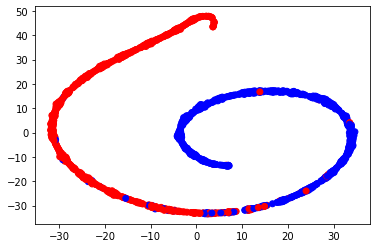

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
color_list = ["red",  "blue"]

#loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for data in test_loader:
    emb, pred = model(data.x, data.edge_index, data.batch)
    embs.append(emb)
    colors += [color_list[y-1] for y in data.y] # True label에 해당하는 color 선
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color=colors)

In [9]:
test_acc

0.945054945054945

In [10]:
# from torch_geometric.nn import GraphConv


# class GNN(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super(GNN, self).__init__()
#         torch.manual_seed(12345)
#         self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
#         self.conv2 = GraphConv(hidden_channels, hidden_channels)
#         self.conv3 = GraphConv(hidden_channels, 3)
#         self.lin = Linear(3, dataset.num_classes)

#     def forward(self, x, edge_index, batch):
#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = self.conv2(x, edge_index)
#         x = x.relu()
#         x = self.conv3(x, edge_index)

#         x = global_mean_pool(x, batch)
#         emb = x 
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.lin(x)
        
#         return emb, x

# model = GNN(hidden_channels=64)
# print(model)

In [11]:
# model = GNN(hidden_channels=64)
# print(model)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# for epoch in range(1, 61):
#     train()
#     train_acc = test(train_loader)
#     test_acc = test(test_loader)
#     print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

In [12]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# color_list = ["red",  "blue", "green"]

# #loader = DataLoader(dataset, batch_size=64, shuffle=True)
# embs = []
# colors = []
# for data in test_loader:
#     emb, pred = model(data.x, data.edge_index, data.batch)
#     embs.append(emb)
#     colors += [color_list[y-1] for y in data.y] # True label에 해당하는 color 선
# embs = torch.cat(embs, dim=0)

# xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
# plt.scatter(xs, ys, color=colors)